In [103]:
import torch
from torchcfm.optimal_transport import OTPlanSampler
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *


In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
# alpha = 1 #np.random.uniform(0.5, 1.5)
# beta = 0.1
# gamma = 0.1
# delta = 0.02
dt = 0.001
max_time = 5000/dt

In [106]:
def lotka_volterra(x, y, alpha, beta, gamma, delta, dt):
    dx = (alpha * x - beta * x * y) * dt
    dy = (-gamma * y + delta * x * y) * dt
    return x + dx, y + dy


def simulate_lotka_volterra(alpha, beta, gamma, delta, x0, y0, steps, dt, max_steps):
    x, y = x0, y0
    dt = torch.tensor([dt] * len(steps))
    for i in range(max_steps):
        dt = torch.where(steps > i, dt, 0)
        x, y = lotka_volterra(x, y, alpha, beta, gamma, delta, dt)

    return x, y

In [107]:
def data_generator(num_samples):

    max_steps = 5000
    steps = torch.tensor(np.random.randint(1, max_steps, num_samples))

    x0 = torch.tensor(np.random.randint(1, 40, num_samples))
    y0 = torch.tensor(np.random.randint(1, 40, num_samples))
    alpha = torch.tensor(np.random.uniform(0.5, 1.5, num_samples))
    gamma = torch.tensor(np.random.uniform(0.01, 0.5, num_samples))
    beta = torch.tensor(np.random.uniform(0.01, 0.5, num_samples))
    delta = torch.tensor(np.random.uniform(0.01, 0.05, num_samples))

    x, y = simulate_lotka_volterra(
        alpha, beta, gamma, delta, x0, y0, steps, dt, max_steps
    )
    x = x.unsqueeze(1)
    y = y.unsqueeze(1)
    steps = steps.unsqueeze(1)
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    alpha = alpha.unsqueeze(1)
    gamma = gamma.unsqueeze(1)
    beta = beta.unsqueeze(1)
    delta = delta.unsqueeze(1)
    obs = torch.cat([x, y], dim=1)
    state = torch.cat([x0, y0, steps, alpha, beta, gamma, delta], dim=1)

    return state, obs

In [108]:
def sample_conditional_pt(x0, x1, t, sigma):
    """
    Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

In [109]:
def compute_conditional_vector_field(x0, x1):
    """
    Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch

    Returns
    -------
    ut : conditional vector field ut(x1|x0) = x1 - x0

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    return x1 - x0

In [110]:

sigma = 1e-8
dim = 9
# model = MLP(dim=dim, time_varying=True)
model = torch.nn.Sequential(
    torch.nn.Linear(dim + 1, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, dim),
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
FM = ConditionalFlowMatcher(sigma=sigma)
model.to(device)
num_dims = 7
x, y = data_generator(2000)
batch_size = 2000

dataloader = torch.utils.data.DataLoader(list(zip(x, y)), batch_size=batch_size, shuffle=True)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9 )

loss_arr = []

start = time.time()
for k in range(10000):
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()

        # x1 = x_batch.to(device)
        x1 = torch.cat([x_batch.to(device).float(), y_batch.to(device).float()], dim=-1)
        x0 = (
            torch.tensor(
                np.random.normal([0] * num_dims, 1, size=(batch_size, num_dims))
            )
            .to(device)
            .float()
        )
        x0 = torch.cat([x0, y_batch], dim=-1)

        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        t = t.float().to(device)
        xt = xt.float().to(device)
        ut = ut.float().to(device)

        vt = model(torch.cat([xt, t[:, None]], dim=-1).to(device))
        loss = torch.mean((vt - ut) ** 2)

        loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()
        sheduler.step()

    if (k + 1) % 1000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        # node = NeuralODE(
        #     torch_wrapper(model),
        #     solver="dopri5",
        #     sensitivity="adjoint",
        #     atol=1e-4,
        #     rtol=1e-4,
        # )
        # with torch.no_grad():
        #     x0 = (
        #     torch.tensor(
        #         np.random.normal([0] * num_dims, 1, size=(batch_size, num_dims))
        #         )
        #         .to(device)
        #         .float()
        #         )
        #     x0 = torch.cat([x0, torch.zeros((batch_size, 1)).to(device)], dim=-1).float()
        #     traj = node.trajectory(
        #         x0,
        #         t_span=torch.linspace(0, 1, 100),
        #     )
        #     plot_trajectories(traj.cpu().numpy())
        #     # plt.scatter(x.cpu().detach().numpy()[:, 0], x.cpu().detach().numpy()[:, 1])


1000: loss 46425.992 time 156.25
2000: loss 27807.883 time 166.44
3000: loss 20107.373 time 156.97
4000: loss 9678.409 time 156.09
5000: loss 6354.985 time 158.78
6000: loss 5177.166 time 159.91
7000: loss 4838.958 time 159.92
8000: loss 4598.219 time 193.10
9000: loss 3589.222 time 163.18
10000: loss 4231.521 time 157.04


In [111]:
print(y.mean())

tensor(12.4375, dtype=torch.float64)


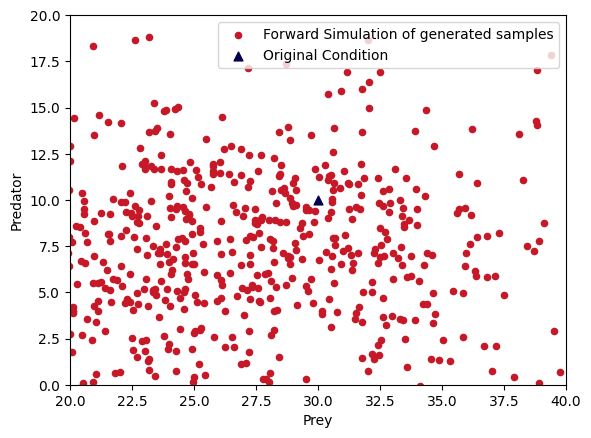

In [112]:
target = [30.0, 10.0]
node = NeuralODE(
            torch_wrapper(model),
            solver="dopri5",
            sensitivity="adjoint",
            atol=1e-4,
            rtol=1e-4,
        )
with torch.no_grad():
        x0 = (
        torch.tensor(
        np.random.normal([0] * num_dims, 1, size=(1000, num_dims))
        )
        .to(device)
        .float()
        )
        x0 = torch.cat([x0, torch.tensor([target]*1000)], dim=-1).float()
        traj = node.trajectory(
        x0,
        t_span=torch.linspace(0, 1, 100),
        )
        angles = traj[-1, :, :7]
        result_x, result_y = simulate_lotka_volterra(
                angles[:, 3],
                angles[:, 4],
                angles[:, 5],
                angles[:, 6],
                angles[:, 0],
                angles[:, 1],
                angles[:, 2],
                dt,
                10,
                )
        # plt.scatter(result_x, result_y,s=5,color = 'orange', label='Forward Simulation of generated samples')
        col_red = '#c61826'
        col_dark_red = '#590d08'
        col_blue = '#01024d'
        plt.scatter(result_x, result_y, s = 20, c = col_red, alpha = 1, label='Forward Simulation of generated samples')
        plt.scatter(target[0], target[1], marker = '^',s = 40, alpha = 1, c=col_blue, label='Original Condition')
        plt.xlim(target[0]-10, target[0]+10)
        plt.ylim(target[1]-10, target[1]+10)
        plt.xlabel('Prey')
        plt.ylabel('Predator')
        plt.legend()
        

In [113]:
print(angles[15])

tensor([1.4127e+01, 8.4941e+00, 9.7650e+02, 8.3442e-01, 2.4449e-01, 4.7793e-01,
        9.7032e-01])


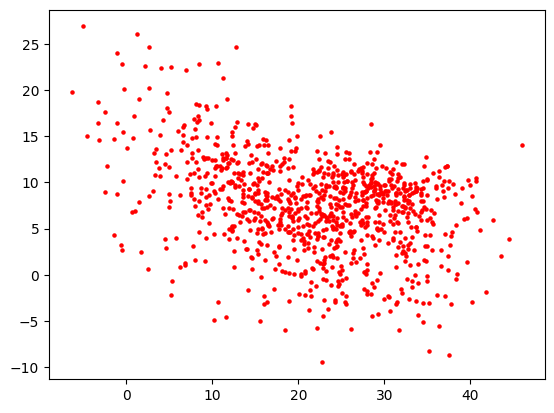

In [114]:
plt.scatter(angles[:, 0], angles[:, 1],s=5, color='red', label='Generated Samples')

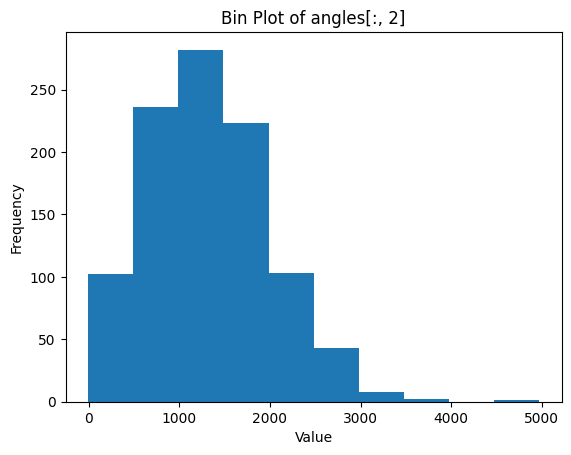

In [115]:
import matplotlib.pyplot as plt

plt.hist(angles[:, 2], bins=10)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Bin Plot of angles[:, 2]')
plt.show()

In [116]:
print(np.mean(result_x.detach().numpy()))

21.62702


In [117]:
print(np.mean(result_y.detach().numpy()))

7.796829


In [118]:
concatenated_array = torch.stack([result_x, result_y])
print(torch.cov(concatenated_array))

tensor([[ 91.3009, -17.4355],
        [-17.4355,  30.2110]])


(0.0, 10.0)

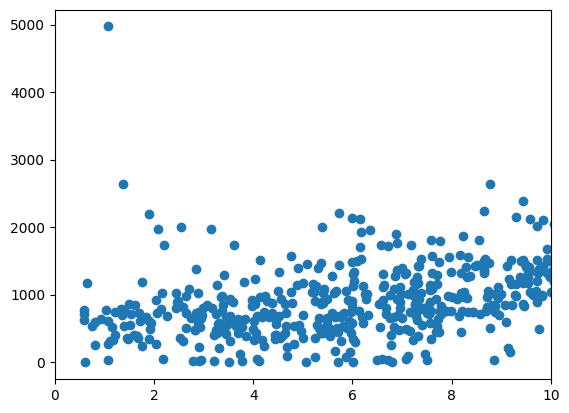

In [119]:
plt.scatter(np.sqrt((result_x.detach().numpy() - target[0])**2 + (result_y.detach().numpy() - target[1])**2), angles[:, 2])
plt.xlim(0, 10)

In [120]:
print(np.mean(np.sqrt((result_x.detach().numpy() - target[0])**2 + (result_y.detach().numpy() - target[1])**2)))

11.952932


In [121]:
print(np.max(np.sqrt((result_x.detach().numpy() - target[0])**2 + (result_y.detach().numpy() - target[1])**2)))

39.627625


In [122]:
print(np.min(np.sqrt((result_x.detach().numpy() - target[0])**2 + (result_y.detach().numpy() - target[1])**2)))

0.58352697


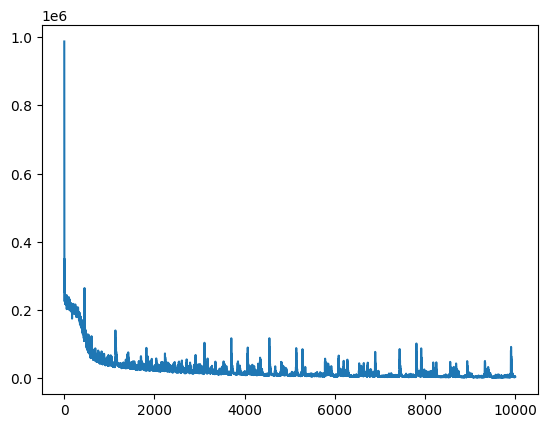

In [123]:
plt.plot(loss_arr)

In [124]:
def MMD(x, y):
        gamma = 2
        xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
        rx = (xx.diag().unsqueeze(0).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))

        dxx = rx.t() + rx - 2. * xx # Used for A in (1)
        dyy = ry.t() + ry - 2. * yy # Used for B in (1)
        rxx = rx[0].repeat(y.shape[0], 1)
        ryy = ry[0].repeat(x.shape[0], 1) 
        dxy = rxx.t() + ryy - 2. * zz # Used for C in (1)

        XX, YY, XY = (torch.zeros(xx.shape).to(device),
                      torch.zeros(yy.shape).to(device),
                      torch.zeros(zz.shape).to(device))
        XX += 1/(1 + dxx/gamma**2)
        YY += 1/(1 + dyy/gamma**2)
        XY += 1/(1 + dxy/gamma**2)
        return XX.mean() + YY.mean() - 2*XY.mean()

In [125]:
print(MMD(x.float(), angles[:, :3].float()))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2000x7 and 3x1000)